### Using workflows in combination with deskewing
* Read a czi image and get the first timepoint
* Generate deskewing workflow, save it, reload and run it again
* Generate a deskewing workflow with filtering, segmentation and labelling and run it

In [1]:
from napari_workflows import Workflow
from napari_workflows._io_yaml_v1 import load_workflow, save_workflow

from skimage.io import imread, imshow,imsave
from skimage.filters import gaussian
import numpy as np

import pyclesperanto_prototype as cle

import matplotlib.pyplot as plt


from aicsimageio import AICSImage, writers
from aicsimageio.types import PhysicalPixelSizes

C:\Users\Pradeep\.conda\envs\napari-lattice\lib\site-packages\skimage\io\manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [2]:
#can be any czi file from lattice 

data_path = 'C:\\RBC_lattice_dataset.czi'
data = AICSImage(data_path)

voxel_size_x_in_microns = data.physical_pixel_sizes.X
voxel_size_y_in_microns = data.physical_pixel_sizes.Y
voxel_size_z_in_microns = data.physical_pixel_sizes.Z

#eventually get angle from metadata
deskewing_angle_in_degrees = 30



In [3]:
image_to_deskew = data.get_image_dask_data("ZYX",T=0,C=0,S=0)
image_to_deskew

dask.array<transpose, shape=(501, 140, 1488), dtype=uint16, chunksize=(501, 140, 1488), chunktype=numpy.ndarray>

In [4]:
deskew_workflow = Workflow()

#define deskewing workflow
#save it

deskew_workflow.set("deskewing", cle.deskew_y, "input", angle_in_degrees = deskewing_angle_in_degrees,
                    voxel_size_x = voxel_size_x_in_microns, voxel_size_y= voxel_size_y_in_microns,
                    voxel_size_z = voxel_size_z_in_microns)



deskew_workflow.set("input", image_to_deskew)

In [5]:
print(deskew_workflow)

Workflow:
deskewing <- (<function deskew_y at 0x00000165EAD114C0>, 'input', None, 30, 1.4499219272808386, 1.4499219272808386, 3.0, 1)
input <- dask.array<transpose, shape=(501, 140, 1488), dtype=uint16, chunksize=(501, 140, 1488), chunktype=numpy.ndarray>



In [6]:
filename = "deskew_workflow.yaml"

save_workflow(filename, deskew_workflow)

In [7]:
new_w = load_workflow(filename)

print(new_w)

Workflow:
deskewing <- (<function deskew_y at 0x00000165EAD114C0>, 'input', None, 30, 1.4499219272808386, 1.4499219272808386, 3.0, 1)



In [8]:
new_w.set("input",image_to_deskew )
print(new_w)

Workflow:
deskewing <- (<function deskew_y at 0x00000165EAD114C0>, 'input', None, 30, 1.4499219272808386, 1.4499219272808386, 3.0, 1)
input <- dask.array<transpose, shape=(501, 140, 1488), dtype=uint16, chunksize=(501, 140, 1488), chunktype=numpy.ndarray>



In [9]:
new_w.get("deskewing")

cl.Array([[[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [ 96.,  94.,  99., ...,  86.,  95.,  93.],
        [ 96.,  94.,  99., ...,  86.,  95.,  93.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.]],

       [[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.]],

       [[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.]],

       ...,

       [[  0.,   0., 

# Deskewing and labelling workflow
* Deskew dask image
* Median filter of 2,2,2
* Background subtraction using top hat sphere (20,20,20)
* Binarisation using a fixed threshold of 5
* Connected components labeling

In [10]:
#save_path = "D:\\deskew_save\\labelled.tif"


image_to_deskew = data.get_image_dask_data("ZYX",T=0,C=0,S=0)

#define deskewing workflow

image_seg_workflow = Workflow()


image_seg_workflow.set("deskewing", cle.deskew_y, "input", angle_in_degrees = deskewing_angle_in_degrees,
                    voxel_size_x = voxel_size_x_in_microns, voxel_size_y= voxel_size_y_in_microns,
                    voxel_size_z = voxel_size_z_in_microns)

image_seg_workflow.set("input", image_to_deskew)

image_seg_workflow.set("median", cle.median_sphere,"deskewing",radius_x = 2, radius_y = 2, radius_z = 2)

image_seg_workflow.set("background_subtraction", cle.top_hat_sphere,"median",radius_x = 20, radius_y = 20, radius_z = 20)

image_seg_workflow.set("binarisation", cle.threshold,"background_subtraction",constant =5)

image_seg_workflow.set("labeling", cle.connected_components_labeling_box,"binarisation")

#image_seg_workflow.set("save_image", imsave, save_path, arr ="labeling")

print(str(image_seg_workflow))

Workflow:
deskewing <- (<function deskew_y at 0x00000165EAD114C0>, 'input', None, 30, 1.4499219272808386, 1.4499219272808386, 3.0, 1)
input <- dask.array<transpose, shape=(501, 140, 1488), dtype=uint16, chunksize=(501, 140, 1488), chunktype=numpy.ndarray>
median <- (<function median_sphere at 0x00000165EAA39820>, 'deskewing', None, 2, 2, 2)
background_subtraction <- (<function top_hat_sphere at 0x00000165EAAA5430>, 'median', None, 20, 20, 20)
binarisation <- (<function greater_constant at 0x00000165EAA24820>, 'background_subtraction', None, 5)
labeling <- (<function connected_components_labeling_box at 0x00000165EAAD7790>, 'binarisation')



In [11]:
filename = "D:\\deskew_seg_workflow.yaml"

save_workflow(filename, image_seg_workflow)

In [12]:
new_deskew = load_workflow(filename)

print(new_deskew)

Workflow:
background_subtraction <- (<function top_hat_sphere at 0x00000165EAAA5430>, 'median', None, 20, 20, 20)
binarisation <- (<function greater_constant at 0x00000165EAA24820>, 'background_subtraction', None, 5)
deskewing <- (<function deskew_y at 0x00000165EAD114C0>, 'input', None, 30, 1.4499219272808386, 1.4499219272808386, 3.0, 1)
labeling <- (<function connected_components_labeling_box at 0x00000165EAAD7790>, 'binarisation')
median <- (<function median_sphere at 0x00000165EAA39820>, 'deskewing', None, 2, 2, 2)



In [13]:
new_deskew.set("input",image_to_deskew)
print(new_deskew)

Workflow:
background_subtraction <- (<function top_hat_sphere at 0x00000165EAAA5430>, 'median', None, 20, 20, 20)
binarisation <- (<function greater_constant at 0x00000165EAA24820>, 'background_subtraction', None, 5)
deskewing <- (<function deskew_y at 0x00000165EAD114C0>, 'input', None, 30, 1.4499219272808386, 1.4499219272808386, 3.0, 1)
labeling <- (<function connected_components_labeling_box at 0x00000165EAAD7790>, 'binarisation')
median <- (<function median_sphere at 0x00000165EAA39820>, 'deskewing', None, 2, 2, 2)
input <- dask.array<transpose, shape=(501, 140, 1488), dtype=uint16, chunksize=(501, 140, 1488), chunktype=numpy.ndarray>



In [14]:
# Run the whole workflow

deskewed_img = new_deskew.get("deskewing")
labelled = new_deskew.get("labeling")

#How do we access intermediate objects without rerunning the whole workflow???
#Can I run the labeling workflow and also get the deskewed_img?


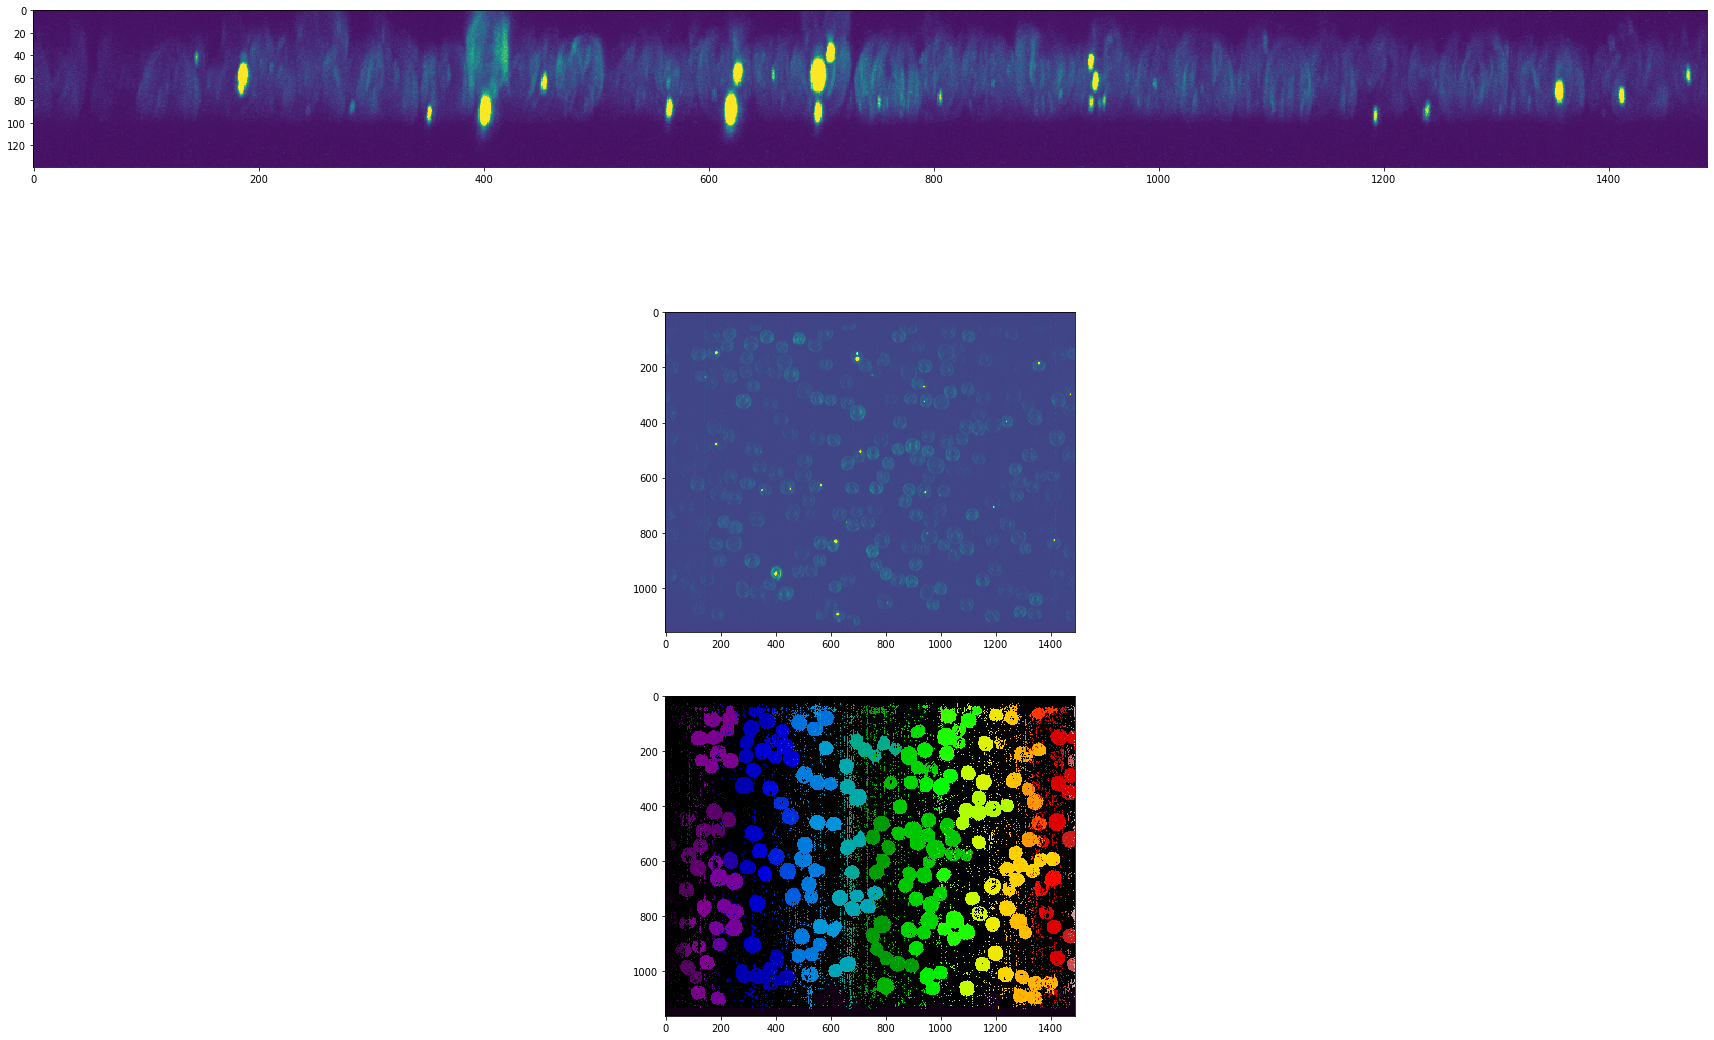

In [15]:
fig,axes = plt.subplots(3,1, figsize=(30,20))
cle.imshow(cle.maximum_z_projection(image_to_deskew),max_display_intensity=500,plot=axes[0])
cle.imshow(cle.maximum_z_projection(deskewed_img),max_display_intensity=500,plot=axes[1])
cle.imshow(cle.maximum_z_projection(labelled), color_map ="nipy_spectral" ,plot=axes[2])

View it in napari if needed

In [38]:
import napari 
viewer = napari.Viewer()

viewer.add_image(image_to_deskew)
viewer.add_image(deskewed_img)
viewer.add_image(labelled)



<Image layer 'labelled' at 0x17062131760>